<a href="https://colab.research.google.com/github/Aravinda89/multi_label_classification/blob/main/Multi_Label_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ! [ -e /content ] && pip install -Uqq fastai2

In [2]:
!pip install fastai==2.0.19 fastcore==1.3.2

     |████████████████████████████████| 188 kB 5.5 MB/s 
     |████████████████████████████████| 46 kB 3.4 MB/s 
     |████████████████████████████████| 5.9 MB 1.5 MB/s 
     |████████████████████████████████| 748.8 MB 18 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.4.0+cu100
    Uninstalling torch-1.4.0+cu100:
      Successfully uninstalled torch-1.4.0+cu100
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.5.0+cu100
    Uninstalling torchvision-0.5.0+cu100:
      Successfully uninstalled torchvision-0.5.0+cu100
  Attempting uninstall: fastcore
    Found existing installation: fastcore 1.3.27
    Uninstalling fastcore-1.3.27:
      Successfully uninstalled fastcore-1.3.27
  Attempting uninstall: fastai
    Found existing installation: fastai 2.0.0
    Uninstalling fastai-2.0.0:
      Successfully uninstalled fastai-2.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are insta

In [3]:
import fastai
print(fastai.__version__)

2.0.19


In [ ]:
# !pip install fastai==2.0.15
# !pip install fastai2==0.0.30
# !pip install fastcore==1.0.16.

# !pip install fastai==2.1.8
# !pip install fastai2==0.0.30
# !pip install fastcore==1.3.26.

In [5]:
# !pip install torch==1.4.0+cu100 torchvision==0.5.0+cu100 -f https://download.pytorch.org/whl/torch_stable.html

In [4]:
from fastai.vision.all import *

import pandas as pd

import torch
from torch import nn

from fastcore.meta import use_kwargs_dict

from fastai.callback.fp16 import to_fp16
from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import lr_find, fit_one_cycle

from fastai.data.block import MultiCategoryBlock, DataBlock
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import RandomSplitter, ColReader

from fastai.metrics import accuracy_multi, BaseLoss

from fastai.vision.augment import aug_transforms
from fastai.vision.data import ImageBlock
from fastai.vision.learner import cnn_learner

In [6]:
import random

In [7]:
planet_source = untar_data(URLs.PLANET_SAMPLE)

In [8]:
planet_source

Path('/root/.fastai/data/planet_sample')

In [9]:
ls '/root/.fastai/data/planet_sample/train'

train_10001.jpg*  train_19451.jpg*  train_28400.jpg*  train_36771.jpg*
train_10007.jpg*  train_19486.jpg*  train_28414.jpg*  train_36778.jpg*
train_10030.jpg*  train_19510.jpg*  train_28430.jpg*  train_36793.jpg*
train_10033.jpg*  train_19547.jpg*  train_28448.jpg*  train_36828.jpg*
train_10042.jpg*  train_19553.jpg*  train_28466.jpg*  train_36849.jpg*
train_1004.jpg*   train_19558.jpg*  train_28481.jpg*  train_36927.jpg*
train_10075.jpg*  train_19617.jpg*  train_28504.jpg*  train_36946.jpg*
train_10082.jpg*  train_19763.jpg*  train_28510.jpg*  train_36960.jpg*
train_10084.jpg*  train_19861.jpg*  train_28522.jpg*  train_37065.jpg*
train_10098.jpg*  train_19865.jpg*  train_28544.jpg*  train_37076.jpg*
train_10125.jpg*  train_19950.jpg*  train_28549.jpg*  train_37090.jpg*
train_10131.jpg*  train_19954.jpg*  train_28613.jpg*  train_37094.jpg*
train_1022.jpg*   train_20151.jpg*  train_28654.jpg*  train_37107.jpg*
train_10241.jpg*  train_20168.jpg*  train_28662.jpg*  train_37123.jpg*
train_

In [10]:
df = pd.read_csv(planet_source/'labels.csv')

In [11]:
df

,image_name,tags
0,train_21983,partly_cloudy primary
1,train_9516,clear cultivation primary water
2,train_12664,haze primary
3,train_36960,clear primary
4,train_5302,haze primary road
...,...,...
995,train_1876,cloudy
996,train_10311,clear primary road water
997,train_19080,clear primary
998,train_39339,clear primary road


In [12]:
df[df['tags'].apply(lambda x:'blow_down' in x)]

,image_name,tags
105,train_38511,blow_down clear primary road


In [13]:
df.drop(index=105, inplace=True)

In [14]:
df

,image_name,tags
0,train_21983,partly_cloudy primary
1,train_9516,clear cultivation primary water
2,train_12664,haze primary
3,train_36960,clear primary
4,train_5302,haze primary road
...,...,...
995,train_1876,cloudy
996,train_10311,clear primary road water
997,train_19080,clear primary
998,train_39339,clear primary road


train_38803
clear primary


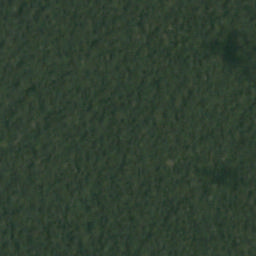

In [17]:
random_index = random.choice(range(len(df['image_name'])))
img_path = df.loc[random_index,'image_name']
img_lbl = df.loc[random_index,'tags']

print(img_path)
print(img_lbl)
im = Image.open('/root/.fastai/data/planet_sample/train/'+img_path+'.jpg').convert('RGB')
im

In [18]:
# DataBlock

In [19]:
batch_tfms = aug_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [20]:
planet = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=ColReader(0, pref=f'{planet_source}/train/', suff='.jpg'),
                   splitter=RandomSplitter(),
                   get_y=ColReader(1, label_delim=' '),
                   batch_tfms = batch_tfms)

In [21]:
dls = planet.dataloaders(df)

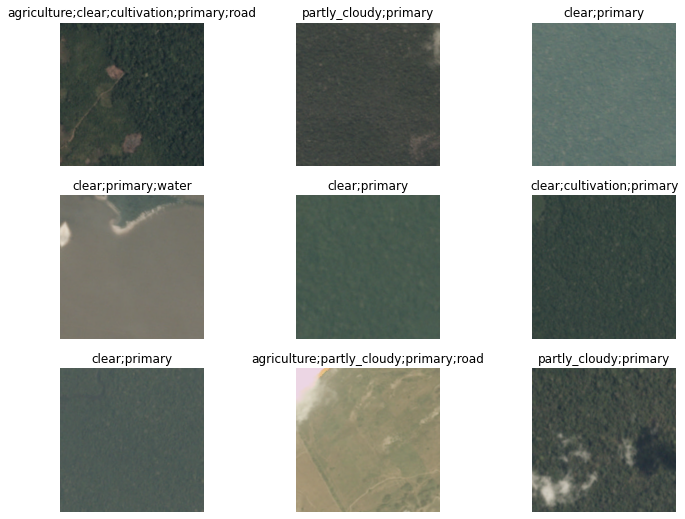

In [28]:
dls.show_batch(max_n=9, figsize=(12,9))

In [30]:
# Lambda

In [40]:
get_x = lambda x:planet_source/'train'/f'{x[0]}.jpg'
get_y = lambda x:x[1].split(' ')

In [42]:
blocks = (ImageBlock, MultiCategoryBlock)

In [43]:
planet = DataBlock(blocks=blocks,
                   get_x=get_x,
                   splitter=RandomSplitter(),
                   get_y=get_y,
                   batch_tfms=batch_tfms)

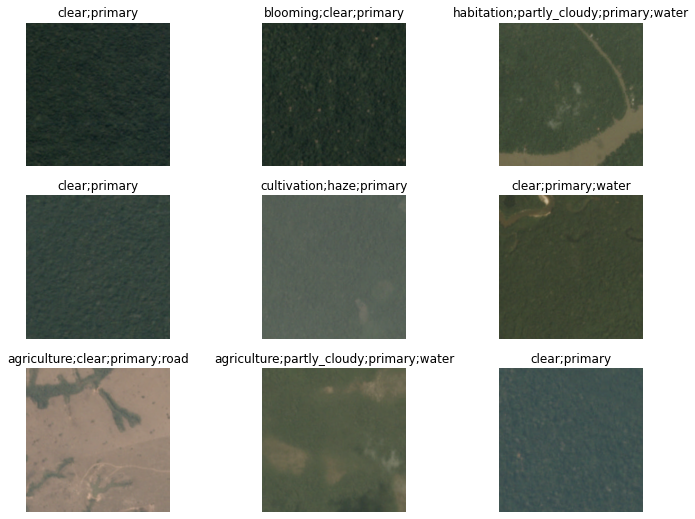

In [45]:
dls = planet.dataloaders(df)
dls.show_batch(max_n=9, figsize=(12,9))